# **IRWA PROJECT - PART 1**

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [93]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
from collections import defaultdict
from array import array
import math
import numpy as np
import collections
import pandas as pd
import json
from numpy import linalg as la

In [94]:
import json

# Ruta al archivo JSON
#docs_path = '/content/drive/My Drive/Rus_Ukr_war_data.json'
docs_path = "Rus_Ukr_war_data.json"

with open(docs_path) as fp:
  lines = fp.readlines()
lines = [l.strip().replace(' +',' ')for l in lines]


### STEP 1: TEXT PROCESSING

In [95]:
# Procesar cada línea (objeto JSON) por separado
lines = [json.loads(line) for line in lines]


In [96]:
# Functions to obtain info about an specific tweet
def get_id(tweet):
    return tweet['id']

def get_text(tweet):
    return tweet['full_text']

def get_hashtags(tweet):
    return [hashtag['text'] for hashtag in tweet['entities']['hashtags']]

def get_likes(tweet):

  l = tweet ['favorite_count']

  if l:
    return l
  else:
    return 0

def get_retweets(tweet):

  r = tweet['retweet_count']

  if r:
    return r
  else:
    return 0

def get_url(tweet):
    return f'https://twitter.com/_/status/{tweet["id"]}'

# Función para obtener la información completa de un tweet en el formato requerido
def get_tweet_info(tweet):
    info = {
        'Id': get_id(tweet),
        'Tweet': get_text(tweet),
        'Username': tweet['user']['screen_name'],
        'Date': tweet['created_at'],
        'Hashtags': ', '.join(get_hashtags(tweet)),
        'Likes': get_likes(tweet),
        'Retweets': get_retweets(tweet),
        'Url': get_url(tweet)
    }
    return info

# Example
index_tweet = 33
tweet_selected = lines[index_tweet]

print(get_tweet_info(tweet_selected))


{'Id': 1575913655102713856, 'Tweet': 'Just take a look at this enthusiasm and patriotic exaltation that #Putler referendum-show generated among the Moskal elites !\n\nOr maybe they can already smell the Criminal Court and the rope on the gallows?\n\n#russia #kacap #UkraineWar #UkraineRussiaWar #Ukraine #Poland #Moscow https://t.co/y689hwasIa', 'Username': 'bsiwekk', 'Date': 'Fri Sep 30 18:21:09 0000 2022', 'Hashtags': 'Putler, russia, kacap, UkraineWar, UkraineRussiaWar, Ukraine, Poland, Moscow', 'Likes': 1, 'Retweets': 0, 'Url': 'https://twitter.com/_/status/1575913655102713856'}


In [97]:
#List for the required information
requested_info = []

# Info for each tweet
for tweet in lines:
    info = get_tweet_info(tweet)
    requested_info.append(info)

# Print that info
requested_info_df = pd.DataFrame(requested_info)
#print(requested_info_df)

pd.set_option('display.float_format', '{:.2f}'.format)
description = requested_info_df.describe()
description = description.drop('Id', axis=1)
print(description)

        Likes  Retweets
count 4000.00   4000.00
mean    11.44      2.12
std    100.27     15.83
min      0.00      0.00
25%      0.00      0.00
50%      1.00      0.00
75%      3.00      1.00
max   3701.00    646.00


In [98]:
!pip install emoji

In [99]:
import emoji

def replace_emojis_with_descriptions(text):
    # Use the emoji library to replace emojis with their descriptions
    return emoji.demojize(text)

text = "I’m still waiting for my google map 🗺️ to update Russia 🇷🇺 new annexed territory but it’s taking a bit longer than I thought 🤔 #Putin #UkraineRussiaWar"

replace_emojis_with_descriptions(text)



'I’m still waiting for my google map :world_map: to update Russia :Russia: new annexed territory but it’s taking a bit longer than I thought :thinking_face: #Putin #UkraineRussiaWar'

In [100]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import re

def build_terms(line):
    """
    Preprocess the text by removing URLs, tags, punctuation, stop words, and perform stemming and lemmatization.

    Arguments:
    line -- string (text) to be preprocessed

    Returns:
    line -- a list of preprocessed tokens
    """

    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    # Transform to lowercase
    line = line.lower()

    # Delete URLs
    line = re.sub(r'http\S+', ' ', line)

    # Delete tags (e.g., @username)
    line = re.sub(r'@\S+', ' ', line)

    # Replace emojis by their descriptions
    line = replace_emojis_with_descriptions(line)

    # Delete punctuation
    line = re.sub(r'[^\w\s]', ' ', line)

    # Tokenize the text to get a list of terms
    line = line.split()

    # Delete empty strings, hashtags, and stopwords
    line = [x for x in line if x not in ('', ' ', '#') and x not in stop_words]

    # Perform stemming and lemmatization
    line = [stemmer.stem(word) for word in line]
    line = [lemmatizer.lemmatize(x) for x in line]

    return line


In [101]:
# List with the processed info
preprocessed_tweets = []


# Pre-process each tweet
for tweet in lines:
    tweet_info = get_tweet_info(tweet)
    tweet_text = build_terms(tweet_info['Tweet'])
    tweet_info['Preprocessed_Tweet'] = tweet_text
    preprocessed_tweets.append(tweet_info)



In [102]:
# Example
index_tweet = 3

# Get preprocessed tweet
preprocessed_tweet = preprocessed_tweets[index_tweet]

# Print relevant information for the preprocessed tweet and the preprocessed tweet itself
for key, value in preprocessed_tweet.items():
    print(f"{key}: {value}")


Id: 1575917907774967809
Tweet: I’m still waiting for my google map 🗺️ to update Russia 🇷🇺 new annexed territory but it’s taking a bit longer than I thought 🤔 #Putin #UkraineRussiaWar
Username: Magzprestige
Date: Fri Sep 30 18:38:03 0000 2022
Hashtags: Putin, UkraineRussiaWar
Likes: 0
Retweets: 0
Url: https://twitter.com/_/status/1575917907774967809
Preprocessed_Tweet: ['still', 'wait', 'googl', 'map', 'world_map', 'updat', 'russia', 'russia', 'new', 'annex', 'territori', 'take', 'bit', 'longer', 'thought', 'thinking_fac', 'putin', 'ukrainerussiawar']


In [103]:
import pandas as pd
docs_path = '/content/drive/MyDrive/Rus_Ukr_war_data_ids.csv'
#docs_path = "Rus_Ukr_war_data_ids.csv"
df = pd.read_csv(docs_path, sep='\t', header = None)
df

,0,1
0,doc_1,1575918221013979136
1,doc_2,1575918081461080065
2,doc_3,1575917992390823936
3,doc_4,1575917907774967809
4,doc_5,1575917878410301441
...,...,...
3995,doc_3996,1575154617620504576
3996,doc_3997,1575154444165156864
3997,doc_3998,1575154440012812288
3998,doc_3999,1575154351273873410


In [104]:
#checking tweet id with the document ids
print(preprocessed_tweets[0]['Id'])
print(preprocessed_tweets[1]['Id'])
print(preprocessed_tweets[2]['Id'])
print(preprocessed_tweets[3999]['Id'])

1575918221013979136
1575918081461080065
1575917992390823936
1575154275759656961


### STEP 2: EXPLORATORY DATA ANALYSIS

In [105]:
# Ruta al archivo JSON
#docs_path = '/content/drive/My Drive/Rus_Ukr_war_data_ids.csv'
docs_path = "Rus_Ukr_war_data.json"

with open(docs_path) as fp:
  lines = fp.readlines()
lines = [l.strip().replace(' +',' ')for l in lines]

In [106]:
# Total number of tweets in the dataset
print("Total number of docs in the corpus: {}".format(len(lines)))

Total number of docs in the corpus: 4000


In [107]:
### CODE TO FIND AVERAGE LENGTH OF TWEETS ###

total_tweets = len(lines)  # Total number of tweets
total_length = 0  # To calculate the total length of tweets in the dataset

for line in lines:
    tweet_data = json.loads(line)  #For each line of json file we load its contents
    full_text = tweet_data['full_text'] #We extract the full text of the tweet
    #print(full_text)
    tweet_length = len(full_text)  # Length of the tweet
    #print(tweet_length)
    total_length += tweet_length  # Aggregates the length to the variable

#print(total_tweets)
#print(total_length)

average_tweet_length = total_length / total_tweets  # Calculation of the average tweet length
print(f"Average tweet length: {average_tweet_length:.2f} characters")



Average tweet length: 211.19 characters


In [108]:
# Empty list for hashtags
hashtags = []

# Iterate through each tweet in 'lines'
for tweet in lines:
    tweet_data = json.loads(tweet)
    tweet_text = tweet_data['full_text'] #obtain the complete text

    words = tweet_text.split()

    # Iterate to find hashtags
    for word in words:
        if word.startswith('#'):

            hashtags.append(word) #aggregate the '#' to the list

# Count the appearences of each hashtag
hashtag_counts = Counter(hashtags)

# Get the top 10 most common hashtags
top_hashtags = hashtag_counts.most_common(10)

# Print the top 10 hashtags
print("Top 10 most common hashtags:")
for tag, count in top_hashtags:
    print(f"{tag}: {count} times")


Top 10 most common hashtags:
#UkraineRussiaWar: 3699 times
#Ukraine: 1860 times
#Russia: 1091 times
#UkraineWar: 1017 times
#Putin: 487 times
#Kherson: 427 times
#NATO: 426 times
#Ukrainian: 404 times
#Russian: 403 times
#USA: 379 times


('#UkraineRussiaWar', '#Ukraine', '#Russia', '#UkraineWar', '#Putin', '#Kherson', '#NATO', '#Ukrainian', '#Russian', '#USA')


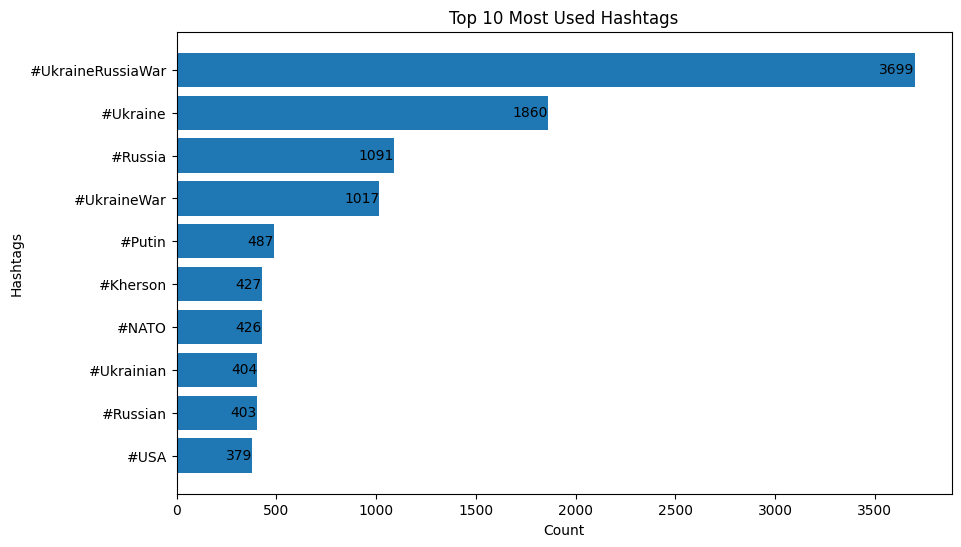

In [109]:
### DISPLAY OF THE PREVIOUS RESULTS ###
# Extract hashtag texts and counts
top_hashtags = hashtag_counts.most_common(10)
hashtags, counts = zip(*top_hashtags)
print(hashtags)


plt.figure(figsize=(10, 6))
plt.barh(hashtags, counts)
plt.xlabel('Count')
plt.ylabel('Hashtags')
plt.title('Top 10 Most Used Hashtags')
plt.gca().invert_yaxis()  # Reverse the order for better visualization

# Add counts as annotations on top of the bars
for i, count in enumerate(counts):
    plt.text(count, i, str(count), ha='right', va='center', fontsize=10)

plt.show()

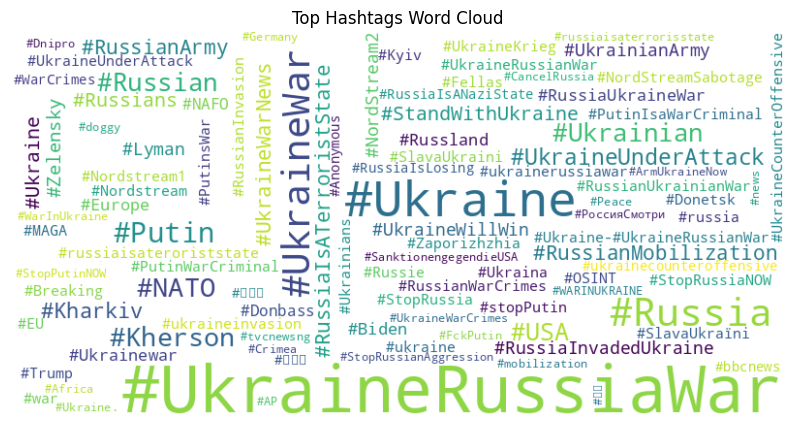

In [110]:
### ANOTHER WAY TO VISUALLY SHOW THESE RESULTS ###

top_hashtags = hashtag_counts.most_common(100) # We increment to 100 as the plot with only 10 # is not really significative

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100, contour_color='black', contour_width=2).generate_from_frequencies(dict(top_hashtags))

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Hashtags Word Cloud')

plt.show()

In [111]:
### CALCULATION OF LIKES AND RETWEETS FOR EACH TWEET AND OTHER COMPUTATIONS ###

# Initialize variables
total_likes = 0
total_retweets = 0
most_liked_tweets = []  # List to store details of the most-liked tweets
max_likes = 0

for line in lines:
    tweet_data = json.loads(line)
    favorite_count = tweet_data['favorite_count']

    # Update total likes and retweets
    total_likes += favorite_count
    total_retweets += tweet_data['retweet_count']

    # Check if this tweet has more likes than the current max
    if favorite_count > max_likes:
        max_likes = favorite_count
        most_liked_tweets = [{
            'full_text': tweet_data['full_text'],  # Store the full text
            'username': tweet_data['user']['screen_name'],  # Store the username
        }]

    # If multiple tweets have the same max likes, add their details
    elif favorite_count == max_likes:
        most_liked_tweets.append({
            'full_text': tweet_data['full_text'],
            'username': tweet_data['user']['screen_name'],
        })

average_likes = total_likes / total_tweets
average_retweets = total_retweets / total_tweets

print("Average likes per tweet:", format(average_likes, ".2f"))
print("Average retweets per tweet:", format(average_retweets, ".2f"))

# Print details of the most-liked tweets
for tweet in most_liked_tweets:
    print("Username of the most-liked tweet:", tweet['username'])
    print("Full text of the most-liked tweet:", tweet['full_text'])
    print("Number of likes for the most-liked tweet:", max_likes)

Average likes per tweet: 11.44
Average retweets per tweet: 2.12
Username of the most-liked tweet: Militarylandnet
Full text of the most-liked tweet: 🗺️Situation around Lyman - Sep 30 11:00:
- UA forces liberated Yampil and advancing north
- RU troops are reportedly abandoning its positions in Drobysheve
- The only exit route from Lyman is within the firing range of UA forces
#UkraineRussiaWar https://t.co/jGJUhXcr1y
Number of likes for the most-liked tweet: 3701
